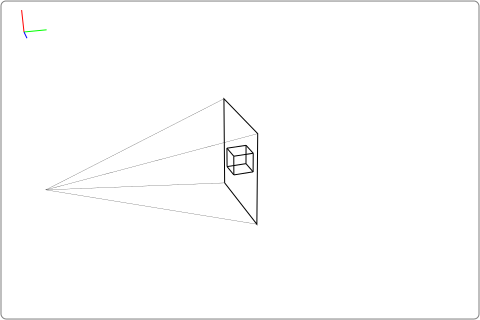

In [1]:
import numpy as np
import tomosipo as ts

pg = ts.cone(size=np.sqrt(2), cone_angle=0.5, angles=np.array([0.0]), shape=(128, 192))

vg = ts.volume(pos=(0.0, 0.0, 0.0), size=0.3)

svg = ts.svg(vg, pg, height=320, width=480, duration=0)
display(svg)

# 5x5 grid

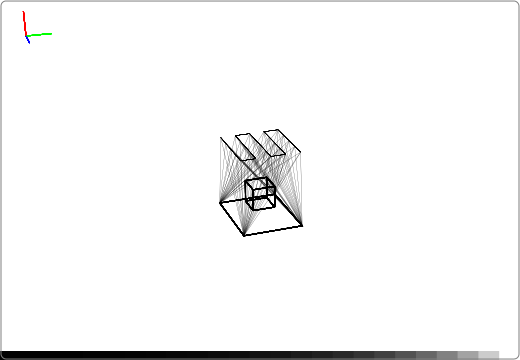

In [2]:
import numpy as np
import tomosipo as ts
import matplotlib.pyplot as plt


vg = ts.volume(
    shape=(64, 64, 64),
    size=(0.3, 0.3, 0.3),
    pos=(-0.2, 0.0, 0.0)
)

# phantom hallow!
x_true = np.ones(vg.shape, dtype=np.float32)
x_true[16:-16, 16:-16, 16:-16] = 0.0


SDD = 1.0
ROWS, COLS = 128, 192
DET_H, DET_W = 0.8, 1.0
px_v, px_u = DET_H/ROWS, DET_W/COLS

det_pos = np.array([[-SDD/2, 0.0, 0.0]])
det_v   = np.array([[0.0,  px_v, 0.0]])
det_u   = np.array([[0.0,  0.0,  px_u]])

Kx, Ky = 5, 5
dx, dy = 0.2, 0.2
x0 = -(Kx-1)*dx/2
y0 = -(Ky-1)*dy/2

# row 0 L→R, row 1 R→L,
src_pos = []
for j in range(Ky):
    xs = [x0 + i*dx for i in range(Kx)]
    if j % 2 == 1: xs = xs[::-1]
    y = y0 + j*dy
    for xx in xs:
        src_pos.append([+SDD/2, y, xx])
src_pos = np.array(src_pos)
V = len(src_pos)

det_pos_all = np.repeat(det_pos, V, axis=0)
det_v_all   = np.repeat(det_v,   V, axis=0)
det_u_all   = np.repeat(det_u,   V, axis=0)

pg = ts.cone_vec(
    shape=(ROWS, COLS),
    src_pos=src_pos,
    det_pos=det_pos_all,
    det_v=det_v_all,
    det_u=det_u_all,
)

svg = ts.svg(vg, pg, height=360, width=520, duration=5.0)
display(svg)


/tmp/ipykernel_633540/838311991.py:9: RuntimeWarning: divide by zero encountered in divide
  R = 1.0 / A(ones_x)


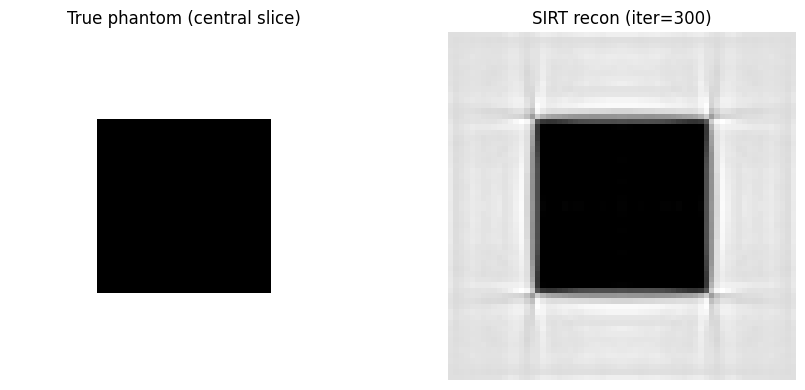

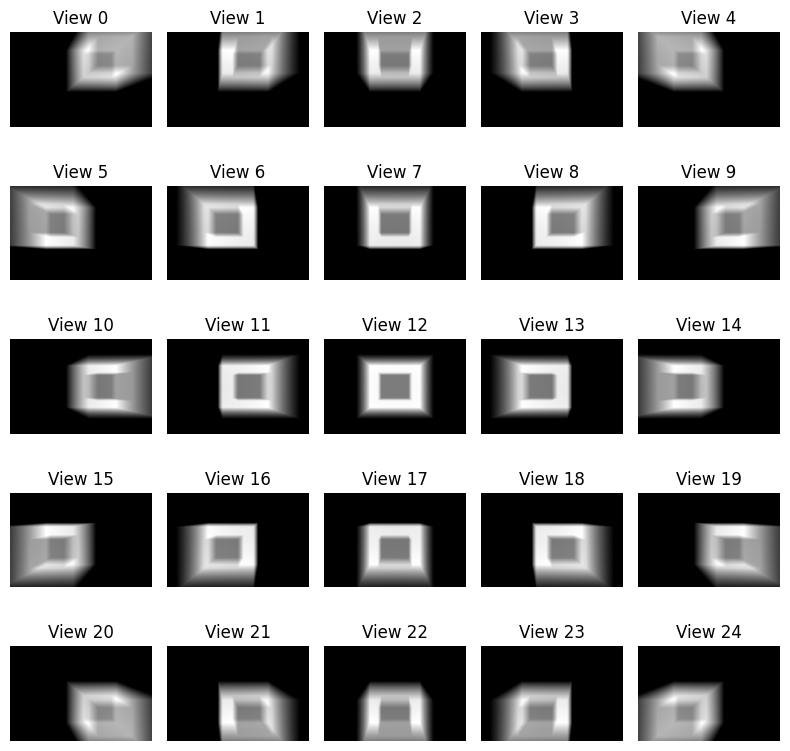

In [3]:
A = ts.operator(vg, pg)

y = A(x_true)

# SIRT from documentation
ones_x = np.ones(A.domain_shape, dtype=np.float32) # ray
ones_y = np.ones(A.range_shape,  dtype=np.float32) # voxel

R = 1.0 / A(ones_x)
R = np.minimum(R, 1.0 / ts.epsilon).astype(np.float32)

C = 1.0 / A.T(ones_y)
C = np.minimum(C, 1.0 / ts.epsilon).astype(np.float32)

# SIRT loop
num_iterations = 300
relax = 1.0
x_rec = np.zeros(A.domain_shape, dtype=np.float32)

for it in range(num_iterations):
    resid = y - A(x_rec)
    x_rec += relax * (C * A.T(R * resid))
    np.maximum(x_rec, 0.0, out=x_rec)

mid = vg.shape[0] // 2
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(x_true[mid], cmap='gray', origin='lower')
plt.title("True phantom (central slice)")
plt.axis('off')

# showing SIRT reco
plt.subplot(1,2,2)
plt.imshow(x_rec[mid], cmap='gray', origin='lower')
plt.title(f"SIRT recon (iter={num_iterations})")
plt.axis('off')
plt.tight_layout()
plt.show()

# plotting all 9 projections
projs = y

axes = np.array(projs.shape)
v_axis = int(np.where(axes == V)[0][0])
projs_v_first = np.moveaxis(projs, v_axis, 0)

fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(V):
    ax = axs[i // 5, i % 5]
    ax.imshow(projs_v_first[i], cmap='gray', origin='lower')
    ax.set_title(f"View {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
import nibabel as nib
import os

# save as .nii for 3d slicer
out_dir = "./reconstruction_output"
os.makedirs(out_dir, exist_ok=True)

x_rec_nii = x_rec.astype(np.float32)

voxel_size = np.array(vg.size) / np.array(vg.shape)

affine = np.diag(np.append(voxel_size, 1.0))

nii_img = nib.Nifti1Image(x_rec_nii, affine)

out_path = os.path.join(out_dir, "reconstruction_3x3.nii")
nib.save(nii_img, out_path)

print(f"NIfTI saved to: {out_path}")


NIfTI saved to: ./reconstruction_output/reconstruction_3x3.nii
